In [ ]:
# Largely taken from: http://blog.yhat.com/posts/interactive-geospatial-analysis.html


## UNCOMMENT AND RUN THESE COMMANDS IF YOU DO NOT HAVE IPYWIDGETS 7.0.0 OR BETTER.
#! pip uninstall ipywidgets
#! pip install ipywidgets

In [1]:
#! pip install geopandas
#! pip install tqdm
#! pip install pysal
! jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# basic stuff
import os
import pandas as pd
import numpy as np
from random import randint, uniform
from datetime import datetime
from urllib.request import urlretrieve
from zipfile import ZipFile
import pysal

# geo stuff
import geopandas as gpd
from shapely.geometry import Point
# from ipyleaflet import (Map,
#     Marker,
#     TileLayer, ImageOverlay,
#     Polyline, Polygon, Rectangle, Circle, CircleMarker,
#     GeoJSON,
#     DrawControl
# )

# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# widget stuff
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

# progress stuff
from tqdm import tqdm_notebook, tqdm_pandas

# turn warnings off
import warnings
warnings.filterwarnings('ignore')

In [3]:
## Let's start off with something small.

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [4]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


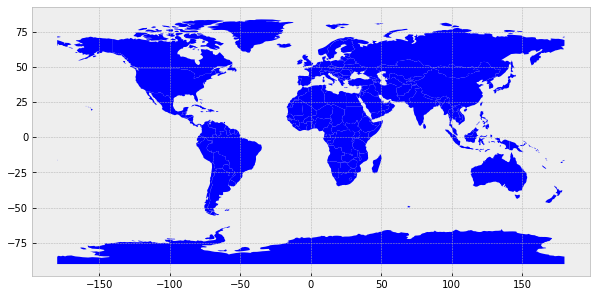

In [5]:
world.plot()

In [6]:
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

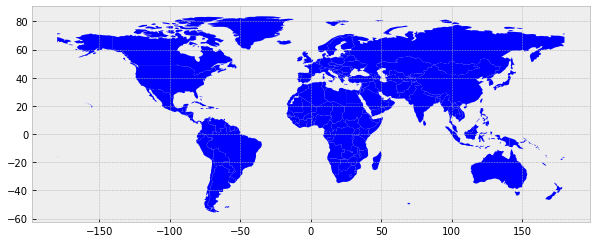

In [7]:
world.plot()

In [8]:
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est

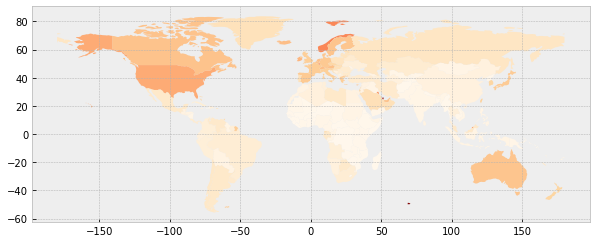

In [9]:
world.plot(column='gdp_per_cap', cmap='OrRd')

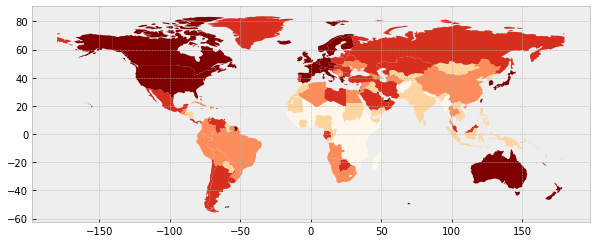

In [10]:
world.plot(column='gdp_per_cap', cmap='OrRd', scheme='quantiles');

In [ ]:
## http://geopandas.org/mapping.html has good information on the above as well as how to map with layers.

In [11]:
def get_nyc_shape_file(url, filename):

    # download file
    zipped = filename + '.zip'
    urlretrieve('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile', zipped)
    zipped = os.getcwd() + '/' + zipped

    # unzip file
    to_unzip = ZipFile(zipped, 'r')
    unzipped = os.getcwd() + '/' + filename + '_unzipped'
    to_unzip.extractall(unzipped)
    to_unzip.close()

    # get shape file
    for file in os.listdir(unzipped):
        if file.endswith(".shp"):
            shape_file = unzipped + '/' + file

    # return full file path
    return shape_file

In [12]:
# get shape file path
shape_file_url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
shape_file_dir = 'nyc_boroughs'
file_path = get_nyc_shape_file(shape_file_url,shape_file_dir)

In [13]:
# read and view GeoDataFrame
gdf = gpd.GeoDataFrame.from_file(file_path)
gdf.head()

,shape_leng,shape_area,boro_name,boro_code,geometry
0,330434.340939,1.623914e+09,Staten Island,5.0,(POLYGON ((-74.05050806403247 40.5664220341608...
1,361657.416718,6.366004e+08,Manhattan,1.0,(POLYGON ((-74.01092841268031 40.6844914725429...
2,741150.814455,1.937596e+09,Brooklyn,3.0,(POLYGON ((-73.86706149472118 40.5820879767934...
3,895729.259626,3.044780e+09,Queens,4.0,(POLYGON ((-73.83668274106707 40.5949466970158...
4,463454.790585,1.186619e+09,Bronx,2.0,(POLYGON ((-73.89680883223774 40.7958084451597...


In [14]:
gdf['geometry']

0    (POLYGON ((-74.05050806403247 40.5664220341608...
1    (POLYGON ((-74.01092841268031 40.6844914725429...
2    (POLYGON ((-73.86706149472118 40.5820879767934...
3    (POLYGON ((-73.83668274106707 40.5949466970158...
4    (POLYGON ((-73.89680883223774 40.7958084451597...
Name: geometry, dtype: object

In [15]:
## http://geopandas.org/reference.html <-- lists all attributes and methods of GeoDataFrames!

gdf['geometry'].centroid

0    POINT (-74.15336945055633 40.58085490444689)
1    POINT (-73.96716967329114 40.77726402055445)
2    POINT (-73.94767617726063 40.64473136667089)
3    POINT (-73.81849492673071 40.70760826931718)
4     POINT (-73.86654179452322 40.8526295510859)
dtype: object

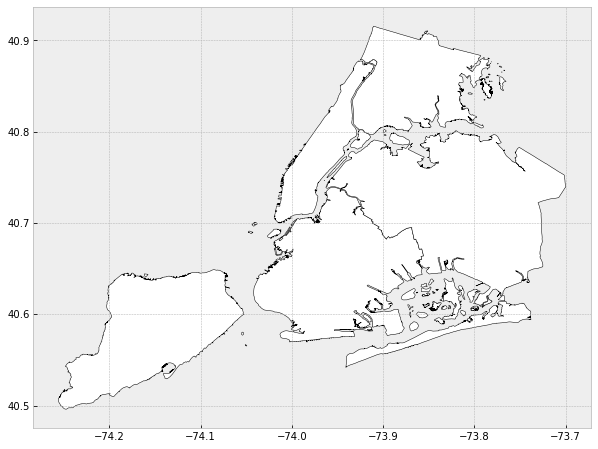

In [16]:
# plot GeoDataFrame
gdf.plot(color='white', edgecolor='black')

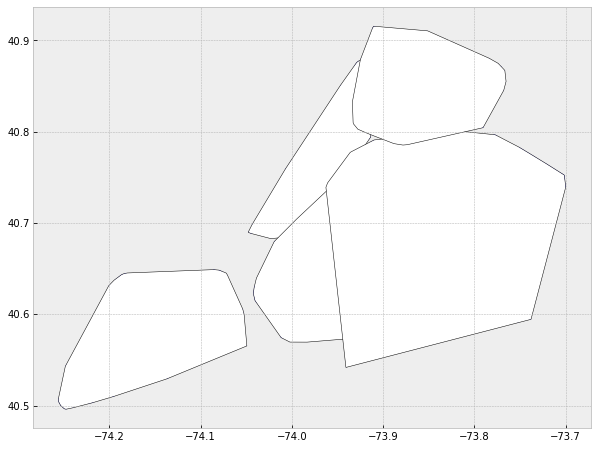

In [17]:
# create convex hulls
hulls = gdf['geometry'].convex_hull

# plot overlay
hulls.plot(ax=gdf.plot(), color='white', edgecolor='black')

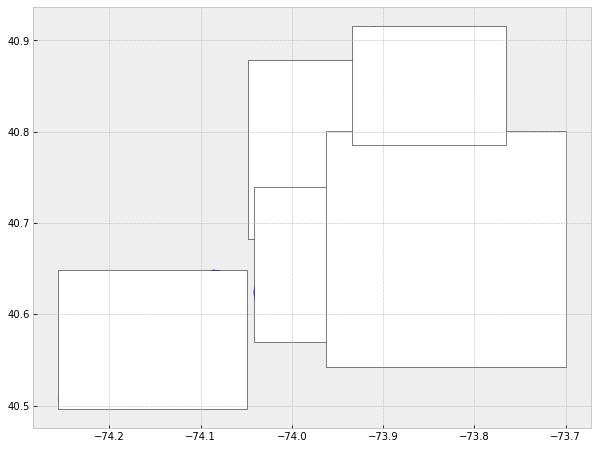

In [18]:
# create envelopes
envelope = gpd.GeoSeries(hulls.envelope)

# plot overlay
envelope.plot(ax=gdf.plot(), color='white', edgecolor='black')

In [19]:
def sim_users(n, p, f):

    # create datetime range
    today = datetime.today().strftime("%m/%d/%Y")
    rng = pd.date_range(today, periods=p, freq=f)

    # get min/max coordinates
    min_x, min_y = gdf['geometry'].bounds.ix[:,:2].min()
    max_x, max_y = gdf['geometry'].bounds.ix[:,2:].max()

    # iterate over time datetime range and create user list
    sim_user_list = []
    for ts in tqdm_notebook(rng, desc='Progress', leave=True):
        for j in range(n):
            x = uniform(min_x, max_x)
            y = uniform(min_y, max_y)
            point = Point(x, y)
            sex = randint(0, 1)
            sim_user_list.append([ts, x, y, point, sex])

    # return dataframe
    sim_user_df = pd.DataFrame(sim_user_list, columns=['datetime', 'x', 'y', 'point', 'sex'])
    return sim_user_df

# simulate user data
sim_data = sim_users(100, 24, 'H')
sim_data.head()

HBox(children=(IntProgress(value=0, description='Progress: ', max=24), HTML(value='')))

,datetime,x,y,point,sex
0,2017-12-06,-74.215398,40.793415,POINT (-74.2153984723669 40.79341484506097),0
1,2017-12-06,-73.802173,40.655542,POINT (-73.80217329259752 40.6555416839094),0
2,2017-12-06,-73.955064,40.848862,POINT (-73.95506357481426 40.84886212110437),1
3,2017-12-06,-74.167635,40.543859,POINT (-74.16763499299216 40.54385934945125),1
4,2017-12-06,-74.009891,40.537697,POINT (-74.00989095821407 40.53769691709802),0


In [20]:
sim_data['datetime']

0      2017-12-06 00:00:00
1      2017-12-06 00:00:00
2      2017-12-06 00:00:00
3      2017-12-06 00:00:00
4      2017-12-06 00:00:00
5      2017-12-06 00:00:00
6      2017-12-06 00:00:00
7      2017-12-06 00:00:00
8      2017-12-06 00:00:00
9      2017-12-06 00:00:00
10     2017-12-06 00:00:00
11     2017-12-06 00:00:00
12     2017-12-06 00:00:00
13     2017-12-06 00:00:00
14     2017-12-06 00:00:00
15     2017-12-06 00:00:00
16     2017-12-06 00:00:00
17     2017-12-06 00:00:00
18     2017-12-06 00:00:00
19     2017-12-06 00:00:00
20     2017-12-06 00:00:00
21     2017-12-06 00:00:00
22     2017-12-06 00:00:00
23     2017-12-06 00:00:00
24     2017-12-06 00:00:00
25     2017-12-06 00:00:00
26     2017-12-06 00:00:00
27     2017-12-06 00:00:00
28     2017-12-06 00:00:00
29     2017-12-06 00:00:00
               ...        
2370   2017-12-06 23:00:00
2371   2017-12-06 23:00:00
2372   2017-12-06 23:00:00
2373   2017-12-06 23:00:00
2374   2017-12-06 23:00:00
2375   2017-12-06 23:00:00
2

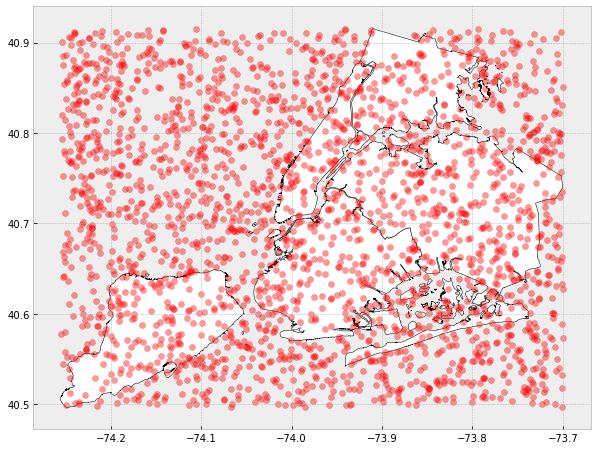

In [21]:
# plot simulated data points
gdf.plot(color='white', edgecolor='black')
plt.scatter(x=sim_data['x'], y=sim_data['y'], alpha=0.4, c='r')

In [22]:
import time
# check if point(s) fall within known geometry - actual
t0 = time.time()
sim_data['contains_1'] = sim_data['point'].map(lambda x: True if gdf.contains(x).any()==True else False)
t1 = time.time()

print(t1 - t0)

28.989294052124023


In [23]:
sim_data['contains_1'].head(10)

0    False
1     True
2    False
3     True
4    False
5    False
6    False
7    False
8    False
9    False
Name: contains_1, dtype: bool

In [24]:
# check if point(s) fall within known geometry - convex hulls
t0 = time.time()
sim_data['contains_2'] = sim_data['point'].map(lambda x: True if hulls.contains(x).any()==True else False)
t1 = time.time()

print(t1 - t0)

0.7279698848724365


In [25]:
# check if point(s) fall within known geometry - envelopes
t0 = time.time()
sim_data['contains_3'] = sim_data['point'].map(lambda x: True if envelope.contains(x).any()==True else False)
t1 = time.time()

print(t1 - t0)

0.501978874206543


In [26]:
def make_plot(hour=1):

    # filter dataframe
    temp = sim_data[sim_data['contains_2']==True]
    temp=temp[temp['datetime'].dt.hour==hour]

    # plot
    hulls.plot(ax=gdf.plot(), color='white', edgecolor='black')
    plt.scatter(x=temp['x'], y=temp['y'], s=30)

# create widget
interact(make_plot, hour=(1, 23, 1))

interactive(children=(IntSlider(value=1, description='hour', max=23, min=1), Output()), _dom_classes=('widget-interact',))

<function __main__.make_plot>